# Quick Start

In [4]:
import PySpice
import PySpice.DeviceLibrary
import PySpice.Doc
import PySpice.Doc.ExampleTools
import sympy
import tqdm

# # Custom Imports
# from macanalog_symbolix.filter import Filter_Classifier
# from macanalog_symbolix.domains import Filter_Classification, Circuit

In [5]:
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit

net_filename = "simple_highpass"

# Load the netlist
circuit = Circuit.from_netlist_file(f'../../schematics/netlists/{net_filename}.net')

# Simulate the circuit
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(V1=slice(0, 5, 0.1))  # Example DC analysis

# Process the results
for node in analysis.nodes.values():
    print(f"{node}: {float(node):.3f} V")


AttributeError: type object 'Circuit' has no attribute 'from_netlist_file'

In [ ]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_V, u_Ohm, u_F, u_Hz
from matplotlib.pyplot import semilogx, xlabel, ylabel, grid, show

import numpy as np

# Define the low-pass filter circuit
circuit = Circuit('Low-Pass Filter')
circuit.SinusoidalVoltageSource(1, 'input', circuit.gnd, amplitude=1 @ u_V)  # AC source
circuit.C(1, 'input', 'output', 1e-6 @ u_F)  # 1 uF capacitor
circuit.R(1, 'output', circuit.gnd, 1e3 @ u_Ohm)  # 1 kOhm resistor


# Simulate the circuit
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(variation='dec', start_frequency=1 @ u_Hz, stop_frequency=1e6 @ u_Hz, number_of_points=100)

# Plot the results
semilogx(analysis.frequency, 20*np.log(abs(analysis['output'])))  # Magnitude of the output voltage
xlabel('Frequency [Hz]')
ylabel('|V_out| [V]')
grid()
show()


In [ ]:
print("Available nodes:", list(analysis.nodes.keys()))
for node in analysis.nodes.keys():
    print(f"{node}: {(abs(analysis[node]))}")

# Example Circuits

## Simulating a MOSFET using PySpice
Tutorial from [link](https://www.linkedin.com/pulse/simulating-mosfet-using-pyspice-yamil-garcia-etsue/)

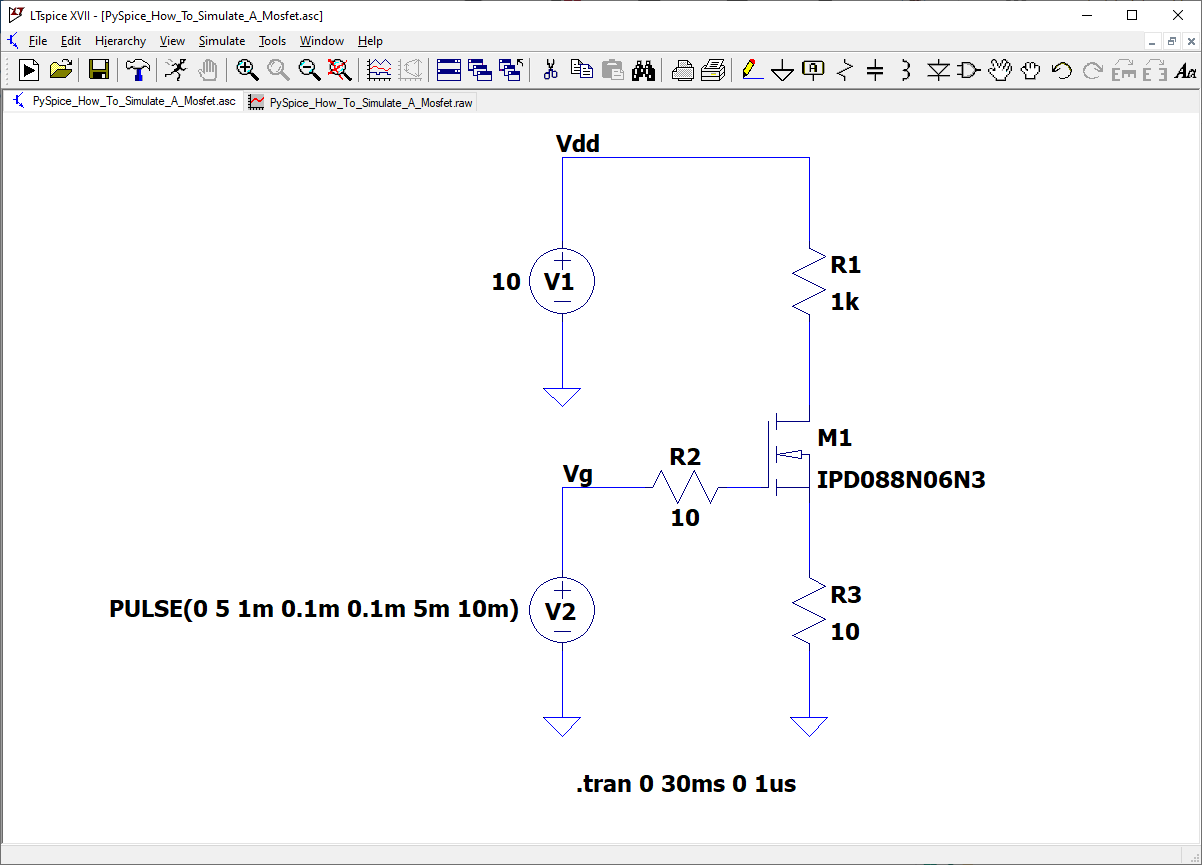

In [6]:
# Step 1 - Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [7]:
# Step 2 - initialize the circuit
circuit = Circuit("Enhanced MOSFET Parametrized Model Test Circuit")
print(circuit)

.title Enhanced MOSFET Parametrized Model Test Circuit




The MOSFET model uses a range of parameters to describe the electrical characteristics and behavior of the transistor. Each parameter influences the MOSFET’s performance in simulations, covering aspects such as threshold voltage, capacitances, resistances, and other dynamic properties. Here's a detailed model:

In [8]:
# Step 3 - Define the MOSFET Model
circuit.model("IPD088N06N3", "NMOS", RG=0.9, VTO=4.35, RD=3.88e-3, 
              RS=1.29e-3, RB=2.76e-3, KP=94.9, LAMBDA=0.01, 
              CGDMIN=7e-12, CGDMAX=0.75e-9, M=0.3, IS=5.8e-12,
              VJ=0.9, N=1.06, TT=30e-9, KSUBTHRES=0.1, 
              RON=8.8e-3, QG=36e-9)
print(circuit)

.title Enhanced MOSFET Parametrized Model Test Circuit

.model IPD088N06N3 NMOS (CGDMAX=7.5e-10 CGDMIN=7e-12 IS=5.8e-12 KP=94.9 KSUBTHRES=0.1 LAMBDA=0.01 M=0.3 N=1.06 QG=3.6e-08 RB=0.00276 RD=0.00388 RG=0.9 RON=0.0088 RS=0.00129 TT=3e-08 VJ=0.9 VTO=4.35)



In [9]:
# Step 4 - Define a Pulse Voltage Source
initial_voltage = 0     #0V
pulsed_voltage = 5      #5V
pulse_width = 5e-3      #1ms
period = 10e-3          #10ms
delay_time = 1e-3
rise_time = 0.1e-3
fall_time = 0.1e-3

vgate = circuit.PulseVoltageSource("Pulse",
                                   "Vg", circuit.gnd,
                                   initial_voltage,
                                   pulsed_voltage,
                                   pulse_width,
                                   period,
                                   delay_time=delay_time,
                                   rise_time=rise_time,
                                   fall_time=fall_time,
                                   phase=None,
                                   dc_offset=0
                                   )

In [10]:
# Step 5 - Define the Circuit Components

# Syntax M<name> <drain> <gate> <source> <bulk> <model>
circuit.MOSFET(1, 'drain', 'gate', 'source', 'source', model='IPD088N06N3')

# Define the drain supply voltage (VDD = 10V)
Vdrain = circuit.V(1, 'Vdd', circuit.gnd, 10) 

# Define a resistor in the drain path (1 kOhm)
circuit.R(1, 'Vdd', 'drain', 1e3)

# Define a resistor in the gate path (10 ohm)
circuit.R(2, 'Vg', 'gate', 10)

# Define a resistor in the source path
circuit.R(3, 'source', circuit.gnd, 10)

Resistor R3

In [11]:
# Step 6 - Run the simulation
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1e-6, end_time=30e-3)

Unsupported Ngspice version 44
.model ipd088n06n3 nmos (cgdmax=7.5e-10 cgdmin=7e-12 is=5.8e-12 kp=94.9  ...
unrecognized parameter (cgdmax) - ignored
unrecognized parameter (cgdmin) - ignored
unrecognized parameter (ksubthres) - ignored
unrecognized parameter (n) - ignored
unrecognized parameter (qg) - ignored
unrecognized parameter (rb) - ignored
unrecognized parameter (rg) - ignored
unrecognized parameter (ron) - ignored
unrecognized parameter (tt) - ignored
unrecognized parameter (vj) - ignored


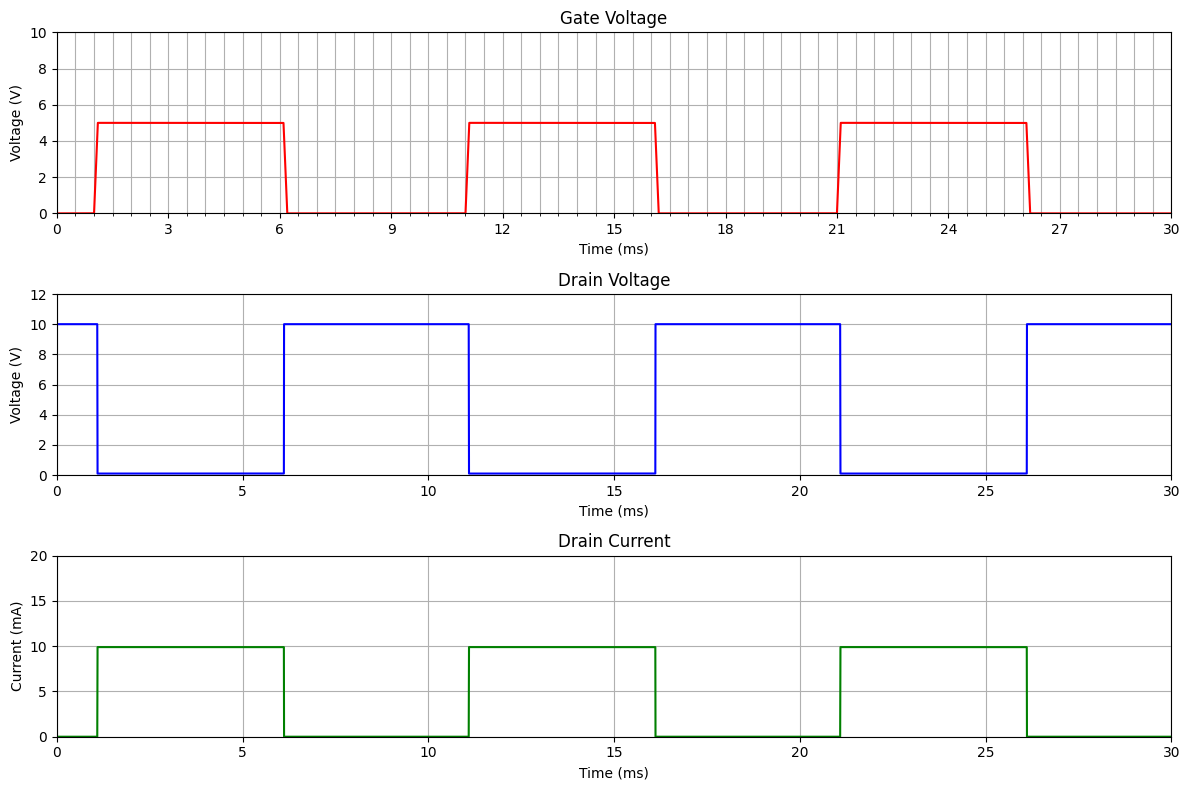

In [58]:
plt.figure(figsize=(12,8))

# Plot the Gate voltage
ax1 = plt.subplot(3,1,1)
plt.plot(np.array(analysis.time * 1e3), np.array(analysis["gate"]), '-r', label='Gate Voltage')
plt.title("Gate Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.xlim(0,30)
plt.ylim(0,10)
ax1.xaxis.set_major_locator(MultipleLocator(3))
ax1.xaxis.set_minor_locator(AutoMinorLocator(6))
plt.grid(True, which='both')

# Plot the Drain voltage
ax2 = plt.subplot(3, 1, 2)
plt.plot(np.array(analysis.time * 1e3), np.array(analysis["drain"]), '-b', label='Drain Voltage')
plt.title("Drain Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.xlim(0,30)
plt.ylim(0,12)
ax1.xaxis.set_major_locator(MultipleLocator(3))
ax1.xaxis.set_minor_locator(AutoMinorLocator(6))
plt.grid(True, which='both')


# Plot the Drain current
ax2 = plt.subplot(3, 1, 3)
plt.plot(np.array(analysis.time * 1e3), 
         ((np.array(analysis["Vdd"]) - np.array(analysis["drain"])) / circuit['R1'].resistance)*1000, 
         '-g', label='Drain Current')
plt.title("Drain Current")
plt.xlabel("Time (ms)")
plt.ylabel("Current (mA)")
plt.xlim(0,30)
plt.ylim(0,20)
ax1.xaxis.set_major_locator(MultipleLocator(3))
ax1.xaxis.set_minor_locator(AutoMinorLocator(6))
plt.grid(True, which='both')

plt.tight_layout()
plt.show()


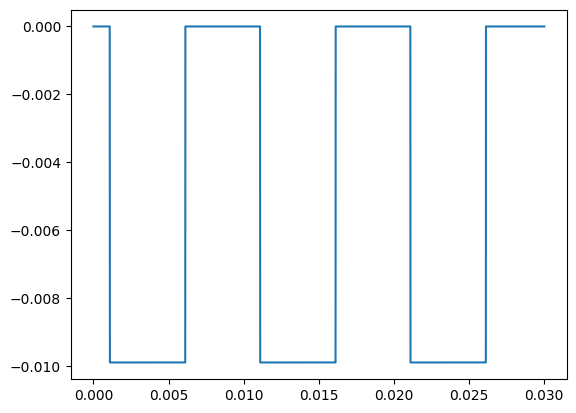

## Example 2

In [61]:
%matplotlib inline